In [14]:
%matplotlib inline
import numpy as np
import scipy.stats as sps
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt

# Ensayo de toxicidad

Se exponen varios grupos de animales a diferentes dosis de un químico tóxico y se quiere analizar cómo la respuesta en términos de supervivencia depende de la dosis.

Léanse los datos del archivo de texto `data/bioassay.txt`

In [15]:
data = pd.read_csv('data/bioassay.txt', skip_blank_lines=False, header=8)
data.head()

,dose,n,y
0,-0.86,5,0
1,-0.30,5,1
2,-0.05,5,3
3,0.73,5,5


In [ ]:
Grafíquense el número de muertes contra la dosis:

Text(0.5,0,'Dose (log g/ml)')

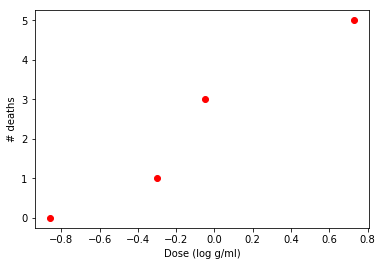

In [17]:
plt.plot(data['dose'], data['y'], 'ro')
plt.ylabel('# deaths')
plt.xlabel('Dose (log g/ml)')

Parece que a medida que la dosis $X$ se incrementa, el número de muertes $Y$ incrementa.

## Modelo lineal

Un modelo sencillo para la dependencia entre $X$ y $Y$ es el modelo lineal
\begin{equation*}
Y = \alpha + \beta X.
\end{equation*}
Desafortunadamente éste modelo no es útil porque $X \in \mathbb{R}$ y por lo tanto $Y \in \mathbb{R}$, i.e., puede predecir un número negativo de muertes, lo cual no tiene sentido.

Alternativamente, podemos de

In [4]:
model = pm.Model()
with model:
    alpha = pm.Flat('alpha')
    beta  = pm.Flat('beta')
    theta = pm.math.invlogit(alpha + beta * data['dose'])
    y     = pm.Binomial('y', p=theta, n=data['n'], observed=data['y'])
    LD50  = pm.Deterministic('LD50', -alpha/beta)

In [5]:
with model:
    trace = pm.sample(2000, target_accept=0.98, random_seed=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:02<00:00, 4693.27draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6404458532192161, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [6]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,1.328815,1.110471,0.023279,-0.675407,3.598493,1969.075168,1.000040
beta,11.754503,5.887390,0.125030,2.667650,23.134656,1831.675823,1.000393
LD50,-0.107067,0.091241,0.001597,-0.277991,0.088740,3466.436277,0.999856


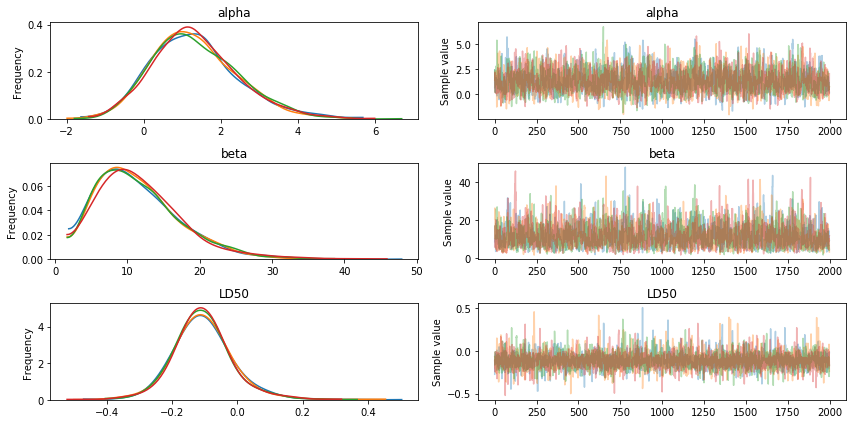

In [7]:
pm.traceplot(trace);

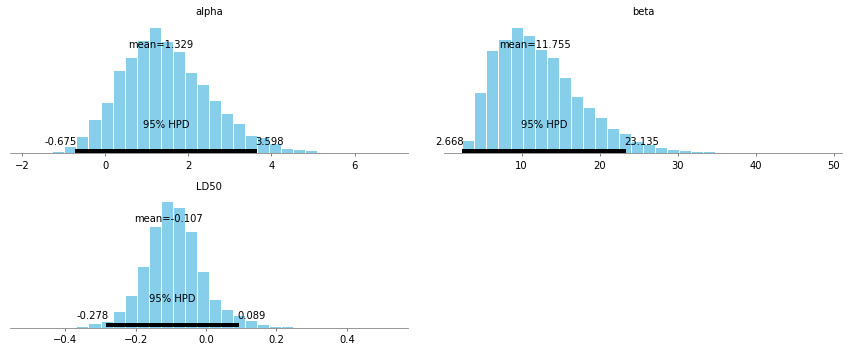

In [8]:
pm.plot_posterior(trace);

In [9]:
with model:
    map = pm.find_MAP()
    
print(map)

/Users/bara947/.local/intelpython3/envs/u18fest_env/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -1.9824, ||grad|| = 0.00044342: 100%|██████████| 14/14 [00:00<00:00, 2942.34it/s]  

{'alpha': array(0.84657861), 'beta': array(7.74880723), 'LD50': array(-0.10925276)}


In [10]:
nppc = 100
ppc  = pm.sample_posterior_predictive(trace, samples=nppc, model=model)

100%|██████████| 100/100 [00:00<00:00, 1331.58it/s]


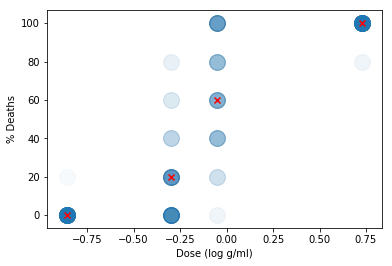

In [11]:
dose_scatter = np.tile(data['dose'].values, (nppc, 1))
ppc['y']
plt.scatter(dose_scatter , 100 * ppc['y']  / 5, alpha=0.03, s=250);
plt.scatter(data['dose'],  100 * data['y'] / 5, c='r', marker='x');
plt.xlabel('Dose (log g/ml)');
plt.ylabel('% Deaths');

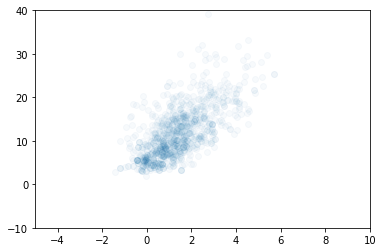

In [12]:
ns=1000
plt.scatter(trace.alpha[:ns], trace.beta[:ns], alpha=0.03)
plt.xlim([-5, 10]);
plt.ylim([-10, 40]);

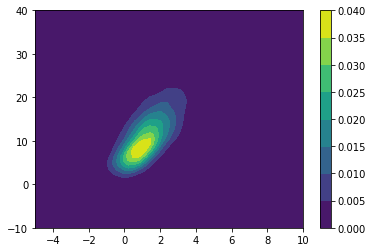

In [13]:
ag, bg = np.mgrid[-5:10:50j, -10:40:50j]
positions = np.vstack([ag.ravel(), bg.ravel()])
kernel = sps.gaussian_kde([trace.alpha, trace.beta])
pdf    = np.reshape(kernel(positions).T, ag.shape)
plt.contourf(ag, bg, pdf)
plt.colorbar()